<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<b>CET Template Notebook</b> <br>
Contact author(s): <i>Author Name</i> <br>
Last verified to run: <i>yyyy-mm-dd</i> <br>
LSST Science Piplines version: Weekly <i>yyyy_xx</i> <br>
Container Size: <i>medium</i> <br>
Targeted learning level: <i>beginner</i> <br>

_In this template, text in italics are examples or instructions that should be: (a) removed if it is not applicable to the notebook; or (b) replaced with text that is appropriate for the notebook. But bold or regular text should appear pretty much as-is in all CET notebooks. For more information, see the [CET's Guidelines for Tutorial Notebooks](https://confluence.lsstcorp.org/pages/viewpage.action?pageId=168857070)._

_While developing, use the following code cell to check that the code conforms to standards, but then delete the cell and "Kernel --> Restart Kernel and Clear All Outputs" before saving and committing._

In [1]:
#%load_ext pycodestyle_magic
#%flake8_on
#import logging
#logging.getLogger("flake8").setLevel(logging.FATAL)

_The six cells below are considered the extended header of the notebook. The first four will be used, verbatim, to create the table of notebook metadata in the README.md file for the repository._

**Description:** _Very brief description of notebook._

**Skills:** _Brief list of skills to match the README.md file for the repository._

**LSST Data Products:** _List the all of the types of LSST catalogs and images used._

**Packages:** _List the python packages used._ (_List the packages being taught first, e.g., afwDisplay for a notebook about displaying images. Then supporting packages, e.g., lsst.daf.butler for a notebook about displaying images. It is OK to leave out basic support packages like os or glob.)_

**Credit:**
_E.g., "Originally developed by" or "Based on notebooks developed by" and then people's names, including journal article or software release citations if appropriate._
Please consider acknowledging them if this notebook is used for the preparation of journal articles, software releases, or other notebooks.

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0-2.lsst.io">dp0-2.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

## 1. Introduction

_Provide a light narrative about this notebook, e.g., "This notebook will teach the user..."._

_Cite or link to any external information or documentation, and cross-reference to other notebooks._

### 1.1 Package Imports

_All package imports should be done in the first code cell._

_Provide explanation or external links to package documentation, where appropriate._

_E.g., Numpy is a fundamental package for scientific computing with arrays in Python (<a href="https://numpy.org">numpy.org</a>)._

_Use code cell comments to describe the packages being imported._

In [2]:
# LSST package for Butler queries
import lsst.daf.butler as dafButler

# LSST package for image display
import lsst.afw.display as afwDisplay

# Import general python packages
import numpy as np
import re
import pandas
from pandas.testing import assert_frame_equal
import uuid
import requests
import warnings
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')

# Science Pipelines imports
from lsst.daf.butler import Butler, DatasetType, CollectionType
import lsst.geom as geom
import lsst.resources
import lsst.afw.image as afwImage
from lsst.afw.image import Image, ImageF
from lsst.afw.image.exposure import Exposure, ExposureF

# Plotting with MPL
import matplotlib.pyplot as plt

# Import the Rubin TAP service utilities
from lsst.rsp import get_tap_service, retrieve_query
from lsst.rsp.utils import get_access_token

# PyVO packages
import pyvo
from pyvo.dal.adhoc import DatalinkResults, SodaQuery

# Astropy
from astropy import units as u
from astropy.units import UnitsWarning
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.time import Time
from astropy.utils.data import download_file
from astropy.visualization import  ZScaleInterval, AsinhStretch
from astropy.wcs import WCS       
from astropy.visualization import simple_norm, imshow_norm
from astropy.visualization import ImageNormalize
from astropy.visualization.stretch import SinhStretch, LinearStretch, SqrtStretch

# Holoviz for interactive visualization
import bokeh
from bokeh.io import output_file, output_notebook, show
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource, CDSView, GroupFilter, HoverTool
from bokeh.plotting import figure
from bokeh.transform import factor_cmap
import holoviews as hv
from holoviews import streams, opts
from holoviews.operation.datashader import rasterize

### 1.2 Define Functions and Parameters

_If your notebook defines functions or parameters to use later or throughout, do it here in sub-section 1.2._

_It is OK to rename the subsection to be more specific to the notebook, and/or to use sub-sub-sections like "1.2.1 Define global cosmological parameter values" or "1.2.2 Define a function to make an image cutout"._

_It is OK to remove this sub-section if it is not being used._

In [3]:
# Set up some plotting defaults
params = {'axes.labelsize': 18,
          'font.size': 18,
          'legend.fontsize': 12,
          'xtick.major.width': 2,
          'xtick.minor.width': 1,
          'xtick.major.size': 10,
          'xtick.minor.size': 4,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 2,
          'axes.linewidth': 2,
          'axes.labelweight': 2,
          'axes.titleweight': 2,
          'ytick.major.width': 2,
          'ytick.minor.width': 1,
          'ytick.major.size': 10,
          'ytick.minor.size': 4,
          'ytick.direction': 'in',
          'ytick.right': True,
          'figure.figsize': [6, 6],
          'figure.facecolor': 'White'
          }

plt.rcParams.update(params)

In [4]:
def plotImage(exposure: ExposureF, img_opt: dict = None):
    """Plot and image using matplotlib
   
   Parameters
    ----------
    image : `Exposure`
        the image to plot
        
    opts : ``
   
   Returns
    -------
    title : `str` (only if result is not `None`)
        Plot title from string
    """
    
    fig, ax = plt.subplots()
    display = afwDisplay.Display(frame=fig)
    display.scale('asinh', 'zscale')
    display.mtv(exposure.image)
    plt.show()


In [5]:
def make_image_cutout(tap_service, ra, dec, cutout_size=0.01, 
                      imtype=None, dataId=None, filename=None): #visit=None, detector=None, filename=None):
    """Make a cutout using the cutout tool
   
   Parameters
    ----------
    # cutout_size is in degrees
    # if imtype None, assumes deepCoadd. dataId must correspond to that for provided imtype
    # TBD supplying band as an option for deepCoadd
    
   Returns
    -------
    
    """

    spherePoint = geom.SpherePoint(ra*geom.degrees, dec*geom.degrees)
    #registry = butler.registry
    if imtype == 'calexp':
        #dataId = {'visit':visit, 'detector':detector}

        query = "SELECT access_format, access_url, dataproduct_subtype, lsst_visit, lsst_detector, " + \
            "lsst_band, s_ra, s_dec FROM ivoa.ObsCore WHERE dataproduct_type = 'image' " + \
            "AND obs_collection = 'LSST.DP02' " + \
            "AND dataproduct_subtype = 'lsst.calexp' " + \
            "AND lsst_visit = " + str(dataId["visit"]) + " " + \
            "AND lsst_detector = " + str(dataId["detector"])
        results = tap_service.search(query) # THIS IS TAP SERVICE

    else:
        # Find the tract and patch that contain this point
        # this is how its done using butler:
        tract = dataId["tract"]
        patch = dataId["patch"]
        
        # add optional default band if it is not contained in the dataId
        band = dataId["band"]

        query = "SELECT access_format, access_url, dataproduct_subtype, lsst_patch, lsst_tract, " + \
            "lsst_band, s_ra, s_dec FROM ivoa.ObsCore WHERE dataproduct_type = 'image' " + \
            "AND obs_collection = 'LSST.DP02' " + \
            "AND dataproduct_subtype = 'lsst.deepCoadd_calexp' " + \
            "AND lsst_tract = " + str(tract) + " " + \
            "AND lsst_patch = " + str(patch) + " " + \
            "AND lsst_band = 'i' "
        results = tap_service.search(query) # THIS IS TAP SERVICE

    #Get datalink
    dataLinkUrl = results[0].getdataurl()
    f"Datalink link service url: {dataLinkUrl}"
    auth_session = service._session
    dl_results = DatalinkResults.from_result_url(dataLinkUrl,session=auth_session)
    f"{dl_results.status}"

    # from_resource: creates a instance from a number of records and a Datalink Resource.
    sq = SodaQuery.from_resource(dl_results, dl_results.get_adhocservice_by_id("cutout-sync"), 
                                 session=auth_session)

    sq.circle = (spherePoint.getRa().asDegrees()* u.deg,
                 spherePoint.getDec().asDegrees()*u.deg, 
                 cutout_size* u.deg)

    #sodaCutout = os.path.join(os.getenv('HOME'), 'DATA/soda-cutout.fits')
    if filename:
        sodaCutout = 'cutouts/'+filename
        #sodaCutout = os.path.join(os.getenv('HOME'), 'DATA/'+filename)
    else:
        #sodaCutout = 'cutouts/soda-cutout.fits'
        sodaCutout = os.path.join(os.getenv('HOME'), 'DATA/soda-cutout.fits')

    with open(sodaCutout, 'bw') as f:
        f.write(sq.execute_stream().read())
        
    #sodaCutout is just the filename...
    return sodaCutout


In [6]:
# some functions from Jeff and Ryan to facilitate animations
def warp_img(ref_img, img_to_warp, ref_wcs, wcs_to_warp):

    config = RegisterConfig()
    task = RegisterTask(name="register", config=config)
    warpedExp = task.warpExposure(img_to_warp, wcs_to_warp, ref_wcs,
                                  ref_img.getBBox())

    return warpedExp

def get_minmax_xy(img, cutout_size):

    cutout_size = int(cutout_size)
    
    height = img.height
    width = img.width

    ceny = (height - 1) / 2
    cenx = (width - 1) / 2

    minx = int(cenx - ((cutout_size - 1) / 2))
    maxx = int(cenx + ((cutout_size - 1) / 2))
    miny = int(ceny - ((cutout_size - 1) / 2))
    maxy = int(ceny + ((cutout_size - 1) / 2))

    return {'minx':minx, 'maxx':maxx, 'miny':miny, 'maxy':maxy}

def make_gif(frame_folder):
    frames = [Image.open(image) for image in sorted(glob.glob(f"{frame_folder}/*.png"))]
    frame_one = frames[0]
    frame_one.save("animation.gif", format="GIF", append_images=frames,
               save_all=True, duration=500, loop=1)


## 2. Generating an image cutout using the cutout tool

_Use numbers for sections, sub-sections, and sub-sub-sections to enable referencing, e.g., "I'm having trouble with the second code cell in Section 2.3."_

_Use section titles that actively describe what is being done, e.g., "Create a color-magnitude diagram" instead of "Plot", so that the auto-generated table of contents is easy to navigate._

### 2.1 Section Sub-heading

#### 2.1.1 Section Sub-sub-heading

In [7]:
# Set afw display backend to matplotlib
afwDisplay.setDefaultBackend('matplotlib')

# Set the maximum number of rows to display from pandas
pandas.set_option('display.max_rows', 20)

In [8]:
butler = Butler('dp02', collections='2.2i/runs/DP0.2')
registry = butler.registry
#butler = Butler(config, collections=collection)


In [9]:
service = get_tap_service()

In [10]:
# galaxy cluster:
#ra = 55.7467 
#dec = -32.2862

# vairable star from tutorial 07b
#ra_known_rrl  = 62.1479031
#dec_known_rrl  = -35.799138

# random DIAobject from a testing code (this ra/dec don't work for some reason
ra = 72.5383603
dec = -44.4248533
diaObjectId = 1253478440036730088

# Define a spatial point
spherePoint = lsst.geom.SpherePoint(ra*geom.degrees, dec*geom.degrees)

#55.75067151347799 -32.27781914678513

# Find the tract and patch that contain this point
skymap = butler.get('skyMap') # skymap is used for coadd projection
tract = skymap.findTract(spherePoint)
patch = tract.findPatch(spherePoint)

# Now create a dataId from the tract, patch and filter information
dataId = {'band':'i', 'tract':tract.tract_id, 'patch': patch.getSequentialIndex()}

# And use the dataid to get the coadd
deepCoadd = butler.get('deepCoadd_calexp', dataId=dataId)

assert type(deepCoadd) == lsst.afw.image.exposure.ExposureF
f"Tract: {tract.tract_id}, Patch: {patch.getSequentialIndex()}"


# Select all images in a region
#query = """SELECT * FROM ivoa.ObsCore 
#WHERE dataproduct_type = 'image'
#AND obs_collection = 'LSST.DP02' 
#AND dataproduct_subtype = 'lsst.deepCoadd_calexp'
#AND CONTAINS(POINT('ICRS', 55.74673760481304, -32.286155241413624), s_region)=1 
#"""
#results = service.search(query).to_table()
#results[1]
#results.to_table().show_in_notebook()

'Tract: 2908, Patch: 12'

In [11]:
t = tract.tract_id
p = patch.getSequentialIndex()

print(tract.tract_id, patch.getSequentialIndex())

query = "SELECT access_format, access_url, dataproduct_subtype, lsst_patch, lsst_tract, " + \
    "lsst_band, s_ra, s_dec FROM ivoa.ObsCore WHERE dataproduct_type = 'image' " + \
    "AND obs_collection = 'LSST.DP02' " + \
    "AND dataproduct_subtype = 'lsst.deepCoadd_calexp' " + \
    "AND lsst_tract = " + str(t) + " " + \
    "AND lsst_patch = " + str(p) + " " + \
    "AND lsst_band = 'i' "
    
results = service.search(query)
results.to_table().show_in_notebook()

2908 12


idx,access_format,access_url,dataproduct_subtype,lsst_patch,lsst_tract,lsst_band,s_ra,s_dec
,,,,,,,deg,deg
0,application/x-votable+xml;content=datalink,https://data.lsst.cloud/api/datalink/links?ID=butler%3A//dp02/746c0042-931d-4454-b193-4981aee12163,lsst.deepCoadd_calexp,12,2908,i,72.59904385606393,-44.327018973175484


## Datalink stuff goes here:


In [12]:
dataLinkUrl = results[0].getdataurl()
f"Datalink link service url: {dataLinkUrl}"
auth_session = service._session
dl_results = DatalinkResults.from_result_url(dataLinkUrl,session=auth_session)
f"{dl_results.status}"

"('OK', 'QUERY_STATUS not specified')"

## here is where the cutout tool code starts:
In some cases it is desirable to be able to perform operations (e.g. image cutouts) on the server side to avoid transferring large amounts of data. This is why it is useful to use this cutout service. See https://www.ivoa.net/documents/DataLink/20211115/WD-DataLink-1.1-20211115.htmlhttps://www.ivoa.net/documents/DataLink/20211115/WD-DataLink-1.1-20211115.html where it says Access Data Services. This is a useful link: https://dmtn-238.lsst.io/https://dmtn-238.lsst.io/

In [13]:
sq = SodaQuery.from_resource(dl_results, dl_results.get_adhocservice_by_id("cutout-sync"), 
                             session=auth_session)


In [14]:
# only 2 shapes supported: circle and polygon. for some reason circle plots as a square (??)

# first do a circle
sphereRadius = 0.001* u.deg

# sq = sodaquery opened earlier
# Defined spatial point was done earlier using spherePoint:
# spherePoint = lsst.geom.SpherePoint(ra*geom.degrees, dec*geom.degrees)

#Example: a circle at (12,34) with radius 0.5:
#CIRCLE=12 34 0.5


sq.circle = (spherePoint.getRa().asDegrees()* u.deg,
             spherePoint.getDec().asDegrees()*u.deg, 
             sphereRadius)


In [15]:
# Testing various ways to skip writing to disk here (not working):

#plotImage(ExposureF(sodaCutout))
#plotImage(ExposureF(sq.execute_stream()))

# THIS DOES NOT WORK, and times out after IOPub data rate exceeded:
#x = sq.execute_stream().read()
#print(x)

#image_url = dl_results.getrecord(0).get('access_url')
#plotImage(ExposureF(image_url))
#plotImage(ExposureF(sq))

# This does not work to pass the cutout without saving
#fig = plt.figure()
#display = afwDisplay.Display(frame=fig)
#display.scale('asinh', 'zscale')
#display.mtv(test)
#plt.show()

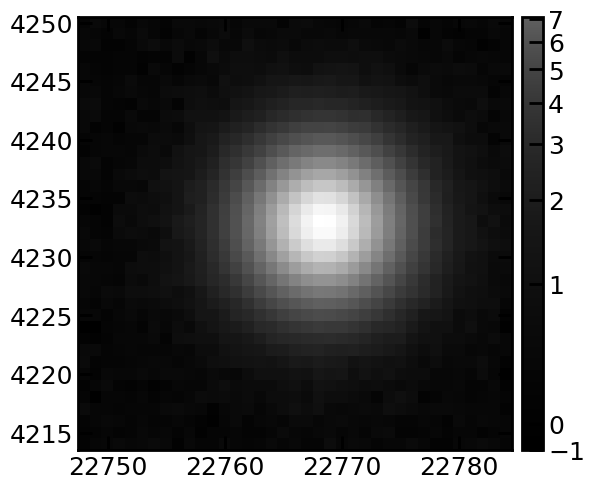

In [16]:
sq = SodaQuery.from_resource(dl_results, dl_results.get_adhocservice_by_id("cutout-sync"), 
                             session=auth_session)

sq.circle = (spherePoint.getRa().asDegrees()* u.deg,
             spherePoint.getDec().asDegrees()*u.deg, 
             sphereRadius)

# first write the file to disk:
sodaCutout = os.path.join(os.getenv('HOME'), 'DATA/soda-cutout.fits')
with open(sodaCutout, 'bw') as f:
    f.write(sq.execute_stream().read())
    
# Display the cutout from the file
plotImage(ExposureF(sodaCutout))


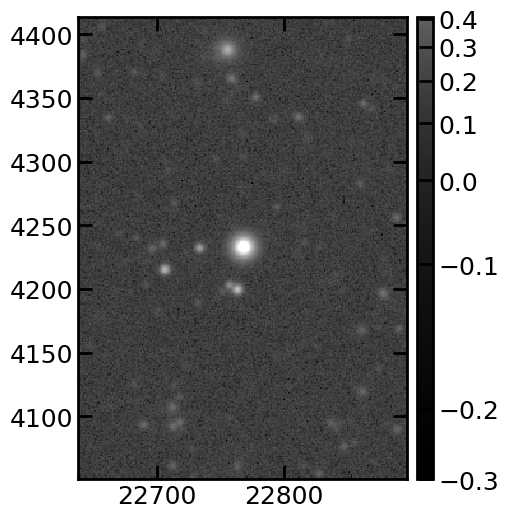

In [17]:
#Alternatively can use polygon to define a region. Actually, circle is easier because there's less to define
#and it looks like "radius" is also half of the box edge. Here's a demonstration using polygon.

#Example: a polygon from (12,34) to (14,34) to (14,36) to (12,36) and (implicitly) back to (12,34):
#POLYGON=12 34 14 34 14 36 12 36
sq2 = SodaQuery.from_resource(dl_results, dl_results.get_adhocservice_by_id("cutout-sync"), 
                             session=auth_session)
sphereRadius2 = 0.01* u.deg

sq2.polygon = (spherePoint.getRa().asDegrees()* u.deg - sphereRadius2,
              spherePoint.getDec().asDegrees()*u.deg - sphereRadius2,
              spherePoint.getRa().asDegrees()* u.deg - sphereRadius2,
              spherePoint.getDec().asDegrees()*u.deg + sphereRadius2,
              spherePoint.getRa().asDegrees()* u.deg + sphereRadius2,
              spherePoint.getDec().asDegrees()*u.deg + sphereRadius2)
              #spherePoint.getRa().asDegrees()* u.deg + sphereRadius2,
              #spherePoint.getDec().asDegrees()*u.deg - sphereRadius2)


sodaCutout2 = os.path.join(os.getenv('HOME'), 'DATA/soda-cutout.fits')
with open(sodaCutout2, 'bw') as f:
    f.write(sq2.execute_stream().read())
    
# Display the cutout
plotImage(ExposureF(sodaCutout2))



### 2.1 Test out a wrapper function "make_image_cutout" defined above, so we can do all the above operations in one go
IT WORKS :-D

In [18]:
#test2 = make_image_cutout(service, dataid, cutout_size=0.005)
#plotImage(ExposureF(test))
# dataId is for the butler, so don't send?
#print(dataId.values())
#print(dataId)
#tracttest = dataId["patch"]

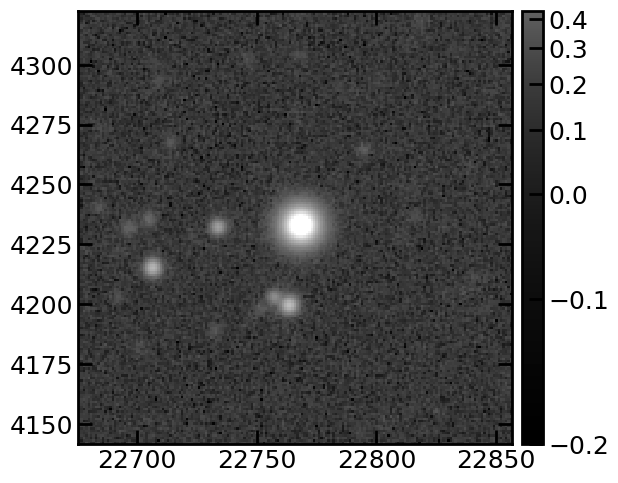

In [19]:
# Test our new function wrapper for the cutout service! IT WORKS :-D

imtype = 'deepCoadd' # this is the default, imtype=None will assume deepCoadd
test = make_image_cutout(service, ra, dec, dataId=dataId, imtype=imtype, cutout_size=0.005)
plotImage(ExposureF(test))


## 3. Creating cutouts of changing flux for the diaObject

_Use numbers for sections, sub-sections, and sub-sub-sections to enable referencing, e.g., "I'm having trouble with the second code cell in Section 2.3."_

_Use section titles that actively describe what is being done, e.g., "Create a color-magnitude diagram" instead of "Plot", so that the auto-generated table of contents is easy to navigate._

### 3.1 Section Sub-heading

#### 3.1.1 Section Sub-sub-heading

In [20]:
# find the source by matching the source ID, which gives you the exact source
query = "SELECT TOP " + str(100) + " " + \
        "diaObjectId, ra, decl, coord_ra, coord_dec, ccdVisitId " + \
        "FROM dp02_dc2_catalogs.DiaSource " + \
        "WHERE diaObjectId = " + str(diaObjectId) + " "

# can get filter and MJD from diasource? If so, then maybe you don't have to do the next cell search
# ccdVisitId = visitid+detector where detector starts with 001
# or could join on ccdVisitId (check if this is an optioN).

print(diaObjectId)
visits = service.search(query)
my_tab = visits.to_table()#.to_pandas()
#my_tab['test'] = np.zeros(len(ccdvisit))

# adding cols to pandas tables should be straitforward
# should be able to join the diasource with ccdvisitid tables. join on ccdvisitid 
# adql functionality join will do it. see notebook 02.

1253478440036730088


In [21]:
# maybe, instead, use Jeff's join query:
# do we need to sort out diaObjectId vs diaSourceId

ccdquery = "SELECT TOP 10 dia.coord_ra, dia.coord_dec, " + \
                        "dia.diaObjectId,  dia.ccdVisitId, dia.band, " + \
                        "cv.visitId, cv.physical_filter, cv.detector, cv.obsStartMJD, " + \
                         "cv.expMidptMJD " + \
                         "FROM dp02_dc2_catalogs.ForcedSourceOnDiaObject as dia " + \
                         "JOIN dp02_dc2_catalogs.CcdVisit as cv ON cv.ccdVisitId = dia.ccdVisitId " + \
                         "WHERE dia.diaObjectId = "+str(diaObjectId)+" AND cv.band = 'i'"
    
diaccdsearch = service.search(ccdquery)
forcedSrc = diaccdsearch.to_table()
forcedSrc
del diaccdsearch

In [22]:
wh = np.argsort(forcedSrc['obsStartMJD'])
forcedSrc[wh]

coord_ra,coord_dec,diaObjectId,ccdVisitId,band,visitId,physical_filter,detector,obsStartMJD,expMidptMJD
deg,deg,,,,,,,,d
float64,float64,int64,int64,object,int64,object,int64,float64,float64
72.5383603,-44.4248533,1253478440036730088,182875032,i,182875,i_sim_1.4,32,59822.2968066,59822.2969802
72.5383603,-44.4248533,1253478440036730088,184843022,i,184843,i_sim_1.4,22,59824.3564446,59824.3566182
72.5383603,-44.4248533,1253478440036730088,214695035,i,214695,i_sim_1.4,35,59870.3281906,59870.3283642
72.5383603,-44.4248533,1253478440036730088,243868055,i,243868,i_sim_1.4,55,59916.1224796,59916.1226532
72.5383603,-44.4248533,1253478440036730088,769363173,i,769363,i_sim_1.4,173,60714.1185356,60714.1187092
72.5383603,-44.4248533,1253478440036730088,932416126,i,932416,i_sim_1.4,126,60946.3480466,60946.3482202
72.5383603,-44.4248533,1253478440036730088,1209664139,i,1209664,i_sim_1.4,139,61361.1071716,61361.1073452
72.5383603,-44.4248533,1253478440036730088,1209697107,i,1209697,i_sim_1.4,107,61361.1239816,61361.1241552


In [23]:
# This cell plots the cutouts by order of MJD 
#def make_image_cutout(butler, tap_service, ra, dec, cutout_size=0.01, imtype=None, visit=None, detector=None, filename=None):

for i in range(10):
    dataId_calexp = {'visit':forcedSrc['visitId'][wh][i], 'detector':forcedSrc['detector'][wh][i]}
    test = make_image_cutout(service, ra, dec, cutout_size=0.005,imtype='calexp', dataId=dataId_calexp)
                             #visit=forcedSrc['visitId'][wh][i], detector=forcedSrc['detector'][wh][i])


    #plotImage(ExposureF(test))




cutouts/ directory already exists
images/ directory already exists
 coord_ra   coord_dec      diaObjectId     ...  obsStartMJD   expMidptMJD 
   deg         deg                         ...                     d      
---------- ----------- ------------------- ... ------------- -------------
72.5383603 -44.4248533 1253478440036730088 ... 59822.2968066 59822.2969802
72.5383603 -44.4248533 1253478440036730088 ... 59824.3564446 59824.3566182
72.5383603 -44.4248533 1253478440036730088 ... 59870.3281906 59870.3283642
72.5383603 -44.4248533 1253478440036730088 ... 59916.1224796 59916.1226532
72.5383603 -44.4248533 1253478440036730088 ... 60714.1185356 60714.1187092
72.5383603 -44.4248533 1253478440036730088 ... 60946.3480466 60946.3482202
72.5383603 -44.4248533 1253478440036730088 ... 61361.1071716 61361.1073452
72.5383603 -44.4248533 1253478440036730088 ... 61361.1239816 61361.1241552
72.5383603 -44.4248533 1253478440036730088 ... 61364.1564246 61364.1565982
72.5383603 -44.4248533 1253478440

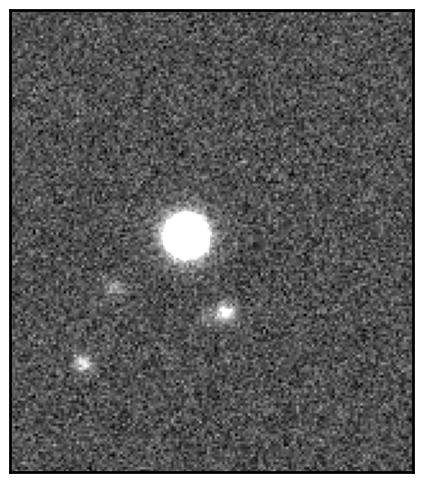

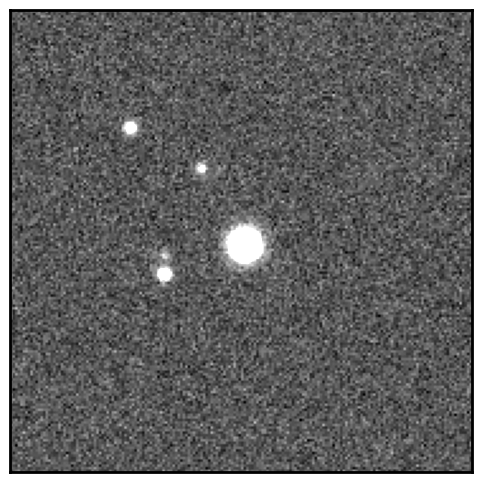

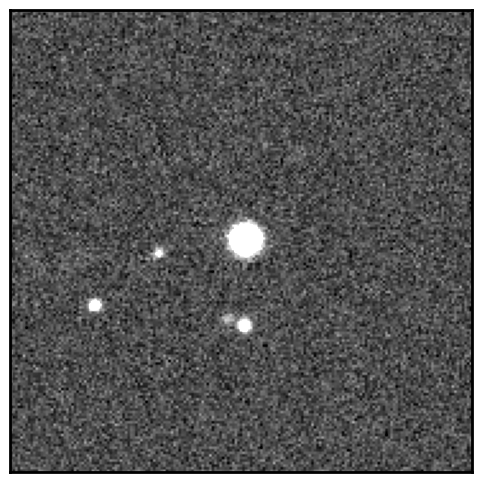

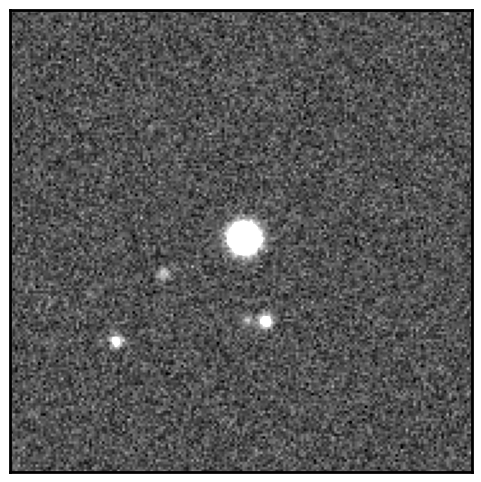

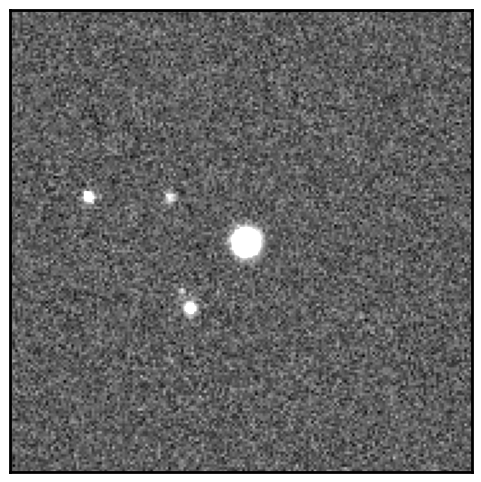

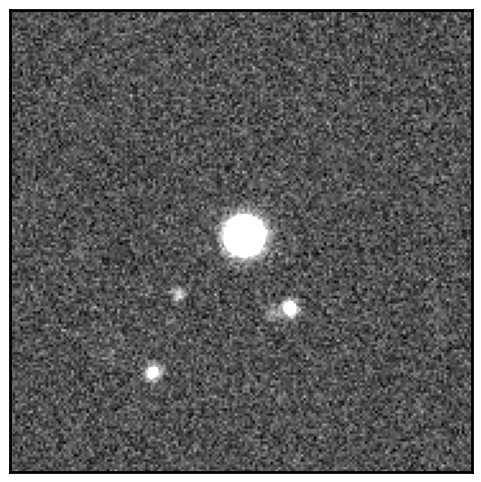

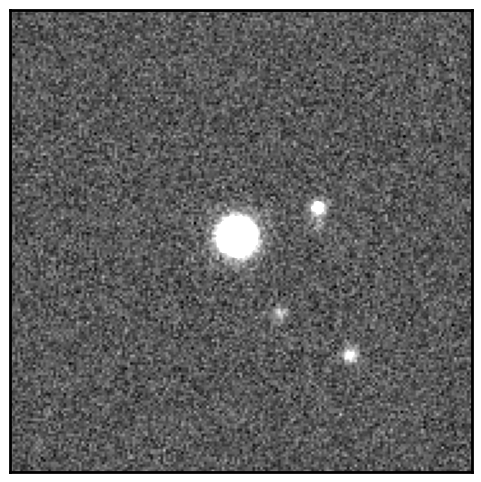

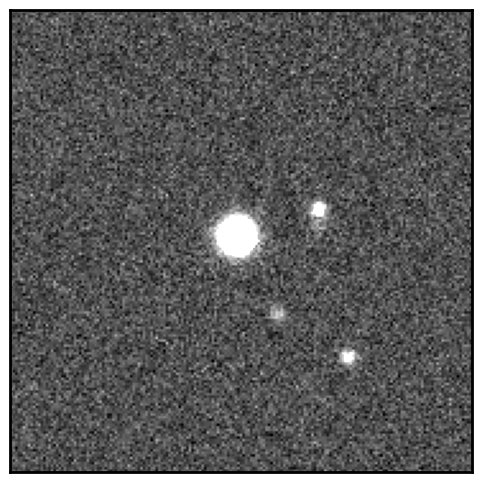

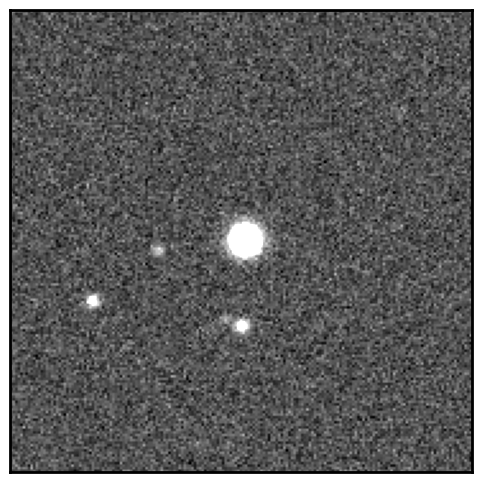

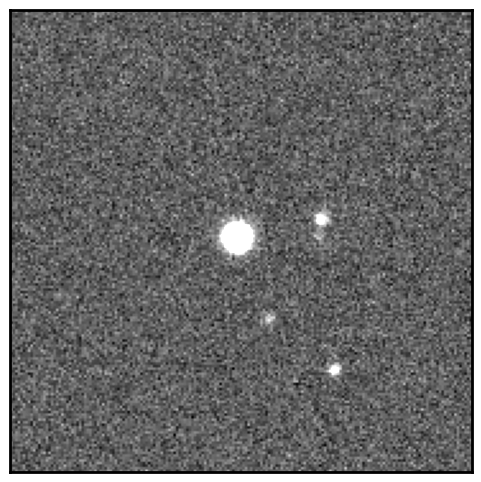

In [24]:
# Jeff's code to generate a gif
if os.path.exists('cutouts'):
    print('cutouts/ directory already exists')
else:
    os.mkdir('cutouts')
    print('Made a cutouts/ directory')

if os.path.exists('images'):
    print('images/ directory already exists')
else:
    os.mkdir('images')
    print('Made an images/ directory')

print(forcedSrc[wh])
#coord_ra	coord_dec	diaObjectId	ccdVisitId	band	visitId	physical_filter	detector	obsStartMJD	expMidptMJD

i = 0
#sys.exit()
for src in forcedSrc[wh]:#diaSrc:
    ccdvisitID = src['ccdVisitId']
    visit = str(ccdvisitID)[:-3]
    detector = str(ccdvisitID)[-3:]
    visit = int(visit)
    detector = int(detector)
    try:
        # JEFF USES diaSourceId and I retained diaObjectId. which is right?
        dataId_calexp = {'visit':src['visitId'], 'detector':src['detector']}
        fitsname = 'cutout_'+str(i)+'.fits'
        make_image_cutout(service, ra, dec, cutout_size=0.005, imtype='calexp',
                          dataId=dataId_calexp, filename=fitsname)
        img = ExposureF('cutouts/'+fitsname)
        
        fig, ax = plt.subplots()

        im_arr = img.image.array
        im_arr_bgnorm = im_arr/np.nanmedian(im_arr)
        
        # Create an ImageNormalize object
        norm = ImageNormalize(im_arr_bgnorm, interval=ZScaleInterval(),
                              stretch=LinearStretch())

        plt.imshow(im_arr_bgnorm, origin='lower', norm=norm, cmap='gray')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        plt.title('MJD: '+str(src['midPointTai'])+'; band: '+str(src['filterName']))
        figname = 'cutouts/cutout_'+str(src['diaObjectId'])+'.png'
        if os.path.isfile(figname):
            os.remove(figname)
        plt.savefig(figname)
        plt.close()
        i+=1
    except:
        # why does the code go here?
        print('Calexp not found for source '+str(src['diaObjectId']))


In [25]:
sys.exit()

SystemExit: 

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-5.1.0/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3406: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Junk code

In [ ]:
# ccdvisittable is a separate catalog that contains all observations and I could use that to extract further info. 
# get detector and visit from ccdvisittable using ccdvisitid. 

ccdqu = "SELECT "  + \
        "ccdVisitId, visitId, physical_filter, band, detector, obsStartMJD " + \
        "FROM dp02_dc2_catalogs.CcdVisit " + \
        "WHERE ccdVisitId = " + str(visits['ccdVisitId'][0]) + " "

# here you have to search on band
# could also return all bands so that you plot all r band and all i band etc sorted by mjd.
# make a colored outline or label the filter int he cutout or something.
# or, chronological order for 1 filter
# user case: want to see if any of the images are bad and so see 

ccdvisit = service.search(ccdqu)
ccdvisit.to_table().to_pandas()
print(ccdvisit)

my_tab['test'] = np.zeros(len(ccdvisit))

In [ ]:
# Write a loop to add these values into one table, so that we can then sort by MJD
# visits = DiaObjs
#print(visits, len(visits))
my_tab['MJD'] = np.zeros(len(visits), dtype='float')
#visits.assign(MJD=0).head()
my_tab['visit'] = np.zeros(len(visits), dtype='float')
my_tab['ccdVisitId_test'] = np.zeros(len(visits), dtype='float')
my_tab['detector'] = np.zeros(len(visits), dtype='float')
my_tab['band'] = np.zeros(len(visits), dtype='float')

# Specify the calexp that we are accessing
#dataId = {'visit': 192350, 'detector': 175, 'band': 'i'}
# Retrieve the data using the `butler` instance and its function `get()`
#calexp = butler.get('calexp', **dataId)


#dont' forget to check Melissa's test NB about imaging in slack
for j in enumerate(visits['ccdVisitId']):
    #print(j)
    ccdqu = "SELECT "  + \
        "ccdVisitId, visitId, physical_filter, band, detector, obsStartMJD " + \
        "FROM dp02_dc2_catalogs.CcdVisit " + \
        "WHERE ccdVisitId = " + str(j[1]) + " " # AND band = 'r' ?
    ccdvisit = service.search(ccdqu).to_table().to_pandas()
    #print(ccdvisit['band'])

    #FSDiaObj['expMidptMJD'][i[0]]=results['expMidptMJD'][0]
    #print(ccdvisit['obsStartMJD'])
    my_tab['MJD'][j[0]] = ccdvisit['obsStartMJD'][0]
    my_tab['visit'][j[0]] = ccdvisit['visitId'][0]
    #my_tab['band'][j[0]] = ccdvisit['band'][0]
    #my_tab['ccdVisitId_test'][j[0]] = ccdvisit['ccdVisitId'][0]
    my_tab['detector'][j[0]] = ccdvisit['detector'][0]
    

    #del ccdvisit


## questions from Melissa
 how can we show failure modes (i.e. if you make a cutout near the boundary) or max sizes on the cutout?
 maybe that goes in Leanne's notebooK? we should test what happens

get a SN near a host galaxy so looks interesting
real science use cases: lensed SN (short time delay with multiple images) when seeing is bad the sources may be blended, and if seeing is good they are deblended. people will lok for DIAobjects close togehter because they might be the same physical thing. Source association pipeline split into multiple ones in cases like this. Ryan-this has already happened (2 DIAobj close to same position and some images will have some sources and other images will have other sources identified. Now you can plot all the
 cutouts (2-4" of eachother). DP0.2 doesnt' have lensed transients so just pick nearby DIAobjs as a demonstrated failure mode which is a good use case. ask Ryan about this (ticket open to explore source association for DIAobj) users can get seeing out of the catalogs (check schema in DIAsource catalog, measurement of PSF? ccdvisit table has it for the whole visit

 another failure mode using variable stars close together maybe seeing differences between visits get blended but maybe SN science app is better. 
 
Ask leanne why we need both butler and tap service to do this (can we get either UUID or datalink from one or the other?)

### questions for melissa 4/26:
### - if you want to have a function that uses a butler instance what is the best way to do that?

## From Melissa 4/26:
 we want to avoid having users write things. See if you can do this without
 writing the file to disk. then you can show an example of how to do that
 but in general we want people not to that
 what is function ExposureF? Does F stand for file?



### Answers for Melissa 4/30/23: 
Yes, F stands for file and this tries to open the file written to disk.

To ask Leanne: is this needed? I only see dataurl for the entire image but can the cutout be stored in memory and not written to disk? Also ask: why isn't the circle cutout actually a circle? Why does polygon also let you define a triangle but also returns a rectangle?

To ask Jeff: did he find this slow (is it because reading/writing files?)
Since the visit and detector are required inputs for the calexp case, it might be good to add a try/except block to make sure they’re provided whenever a  calexp cutout is requested.
Since the visit and detector are required inputs for the calexp case, it might be good to add a try/except block to make sure they’re provided whenever a  calexp cutout is requested.
